# ML-ImmuneProfiler

## Single-Cell RNA-seq Cell Type Classification: Notebook 0

## scRNA-seq raw data preprocessing, normalization, batch effect correction and cell type prediction (Azimuth)

- Date: 2025-04-10

## Overview

This notebook implements the data preprocessing of the raw scRNA-seq datasets with an envision of stage-ready format for ML modelling

Steps implemented:
- Load scRNA-seq datasets
- Filtering out low quality cells and features/genes based on mutli-paramaters approach inclusing viz. inference derivation
- Normalization
- Azimuth based cell type prediction
- Batch effect correction and data samples intergation alonb with filtering of cells based on the cell type distribution to handle class imbalance that might have an impact on ML prediction

## Load Libraries

In [62]:
library(Seurat)
library(tidyverse)
library(purrr)
library(ggprism)
library(ggplot2)
library(clustree) # Clustering
library(patchwork)
library(scDblFinder) # Doublet Analysis
library(svglite)
library(ComplexHeatmap)
library(dplyr)

## sample_1

In [4]:
data1 <- Read10X_h5("data/sample1.h5")

In [7]:
sample1 <- CreateSeuratObject(counts = data1, min.cells = 3, min.features = 200)

In [10]:
# calculate mitocondrial percentages
sample1[["percent.mt"]] <- PercentageFeatureSet(sample1, pattern = "^MT-") #nolint

# calculate ribosome percentages
sample1[["percent.rb"]] <- PercentageFeatureSet(sample1, pattern = "^RP[SL]") #nolint

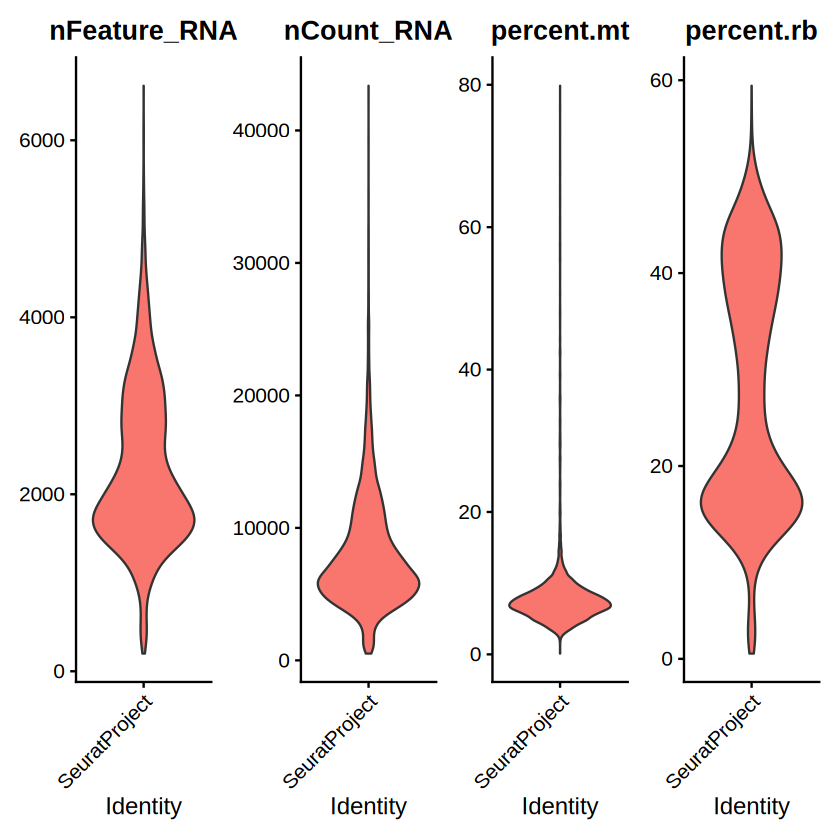

In [11]:
#For displaying in the work arena
VlnPlot(sample1, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb"), ncol = 4, pt.size = 0) # nolint

In [16]:
#Unique features per cell greater than 5000
print(sum(sample1@meta.data$nFeature_RNA > 5000))
#Unique features per cell less than 200
print(sum(sample1@meta.data$nFeature_RNA < 200))
# percent.mt reads per cell less than 20
print(sum(sample1@meta.data$percent.mt > 15))

[1] 0
[1] 0
[1] 0


In [15]:
# Apply filtering
sample1 <- subset(sample1, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 15)

In [18]:
#Increase the global variable import maximum size (Increased to 10GB here)
options(future.globals.maxSize = 10000 * 1024^2)

In [20]:
sample1 <- NormalizeData(sample1)

In [21]:
azimuth_anno1 <- read.table("azimuth_preds/s1_azimuth_pred.tsv", header=TRUE, sep="\t", row.names=1)

In [24]:
str(sample1@meta.data)

'data.frame':	11506 obs. of  5 variables:
 $ orig.ident  : Factor w/ 1 level "SeuratProject": 1 1 1 1 1 1 1 1 1 1 ...
 $ nCount_RNA  : num  12143 7810 9741 5561 7398 ...
 $ nFeature_RNA: int  3022 2666 2934 1525 2077 1549 2520 4491 1158 1749 ...
 $ percent.mt  : num  6.41 6.31 8.64 5.2 8.87 ...
 $ percent.rb  : num  19.6 12.9 17.9 45.6 35.3 ...


In [27]:
common_cells <- intersect(rownames(azimuth_anno1), Cells(sample1))
azimuth_anno1 <- azimuth_anno1[common_cells, ]

In [28]:
sample1 <- AddMetaData(sample1, metadata = azimuth_anno1)

In [29]:
str(sample1@meta.data)

'data.frame':	11506 obs. of  8 variables:
 $ orig.ident                 : Factor w/ 1 level "SeuratProject": 1 1 1 1 1 1 1 1 1 1 ...
 $ nCount_RNA                 : num  12143 7810 9741 5561 7398 ...
 $ nFeature_RNA               : int  3022 2666 2934 1525 2077 1549 2520 4491 1158 1749 ...
 $ percent.mt                 : num  6.41 6.31 8.64 5.2 8.87 ...
 $ percent.rb                 : num  19.6 12.9 17.9 45.6 35.3 ...
 $ predicted.celltype.l2      : chr  "CD16 Mono" "CD14 Mono" "CD14 Mono" "CD4 TCM" ...
 $ predicted.celltype.l2.score: num  1 1 0.795 0.569 0.9 ...
 $ mapping.score              : num  0.894 0.952 0.827 0.873 0.958 ...


## sample_2

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of percent.mt.”


'data.frame':	2691 obs. of  8 variables:
 $ orig.ident                 : Factor w/ 1 level "SeuratProject": 1 1 1 1 1 1 1 1 1 1 ...
 $ nCount_RNA                 : num  2336 4702 3108 2575 959 ...
 $ nFeature_RNA               : int  762 1335 1119 944 516 771 768 780 525 542 ...
 $ percent.mt                 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ percent.rb                 : num  45.1 44.2 31.9 24.7 15.2 ...
 $ predicted.celltype.l2      : chr  "CD8 TCM" "B intermediate" "CD4 TCM" "CD14 Mono" ...
 $ predicted.celltype.l2.score: num  0.818 0.622 0.798 0.589 1 ...
 $ mapping.score              : num  0.898 0.986 0.667 0.975 0.968 ...


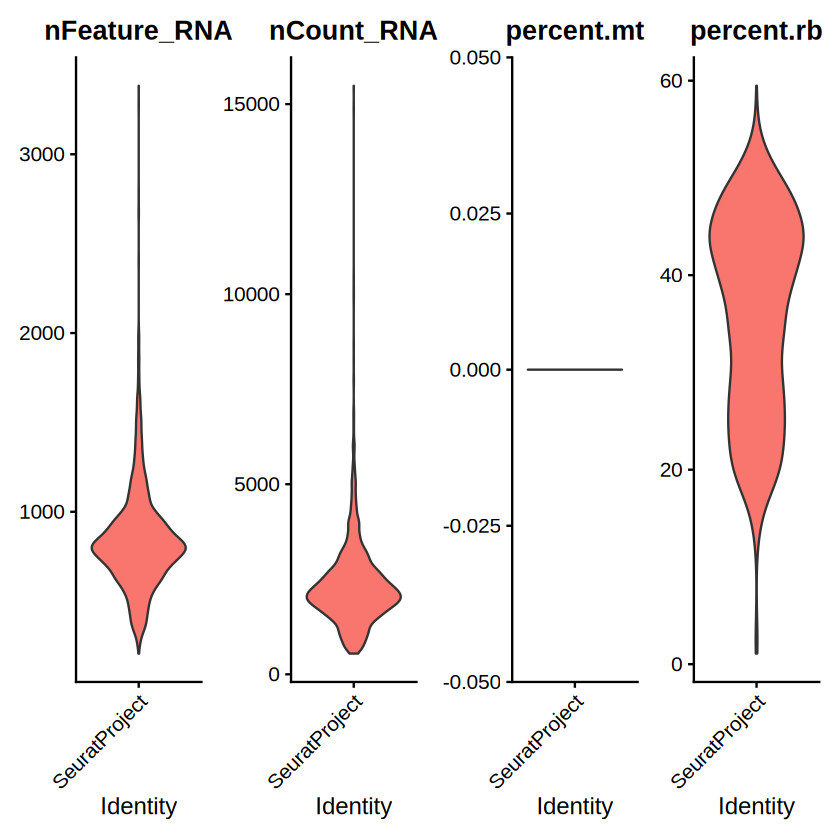

In [34]:
data2 <- Read10X("data/sample2")

sample2 <- CreateSeuratObject(counts = data2, min.cells = 3, min.features = 200)

# calculate mitocondrial percentages
sample2[["percent.mt"]] <- PercentageFeatureSet(sample2, pattern = "^MT-") #nolint


# calculate ribosome percentages
sample2[["percent.rb"]] <- PercentageFeatureSet(sample2, pattern = "^RP[SL]") #nolint

#For displaying in the work arena
VlnPlot(sample2, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb"), ncol = 4, pt.size = 0) # nolint

# Apply filtering
sample2 <- subset(sample2, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 15)

sample2 <- NormalizeData(sample2)

azimuth_anno2 <- read.table("azimuth_preds/s2_azimuth_pred.tsv", header=TRUE, sep="\t", row.names=1)

common_cells <- intersect(rownames(azimuth_anno2), Cells(sample2))
azimuth_anno2 <- azimuth_anno2[common_cells, ]

sample2 <- AddMetaData(sample2, metadata = azimuth_anno2)

str(sample2@meta.data)

## sample_3

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


'data.frame':	33128 obs. of  8 variables:
 $ orig.ident                 : Factor w/ 1 level "SeuratProject": 1 1 1 1 1 1 1 1 1 1 ...
 $ nCount_RNA                 : num  1935 1342 720 1604 1313 ...
 $ nFeature_RNA               : int  713 673 354 753 558 907 492 999 513 866 ...
 $ percent.mt                 : num  1.45 2.98 1.81 3.24 1.98 ...
 $ percent.rb                 : num  41.7 23 29.6 29.5 39.5 ...
 $ predicted.celltype.l2      : chr  "CD4 Naive" "NK" "CD16 Mono" "CD8 TCM" ...
 $ predicted.celltype.l2.score: num  0.532 1 0.821 0.545 0.933 ...
 $ mapping.score              : num  0.746 0.805 0.736 0.527 0.661 ...


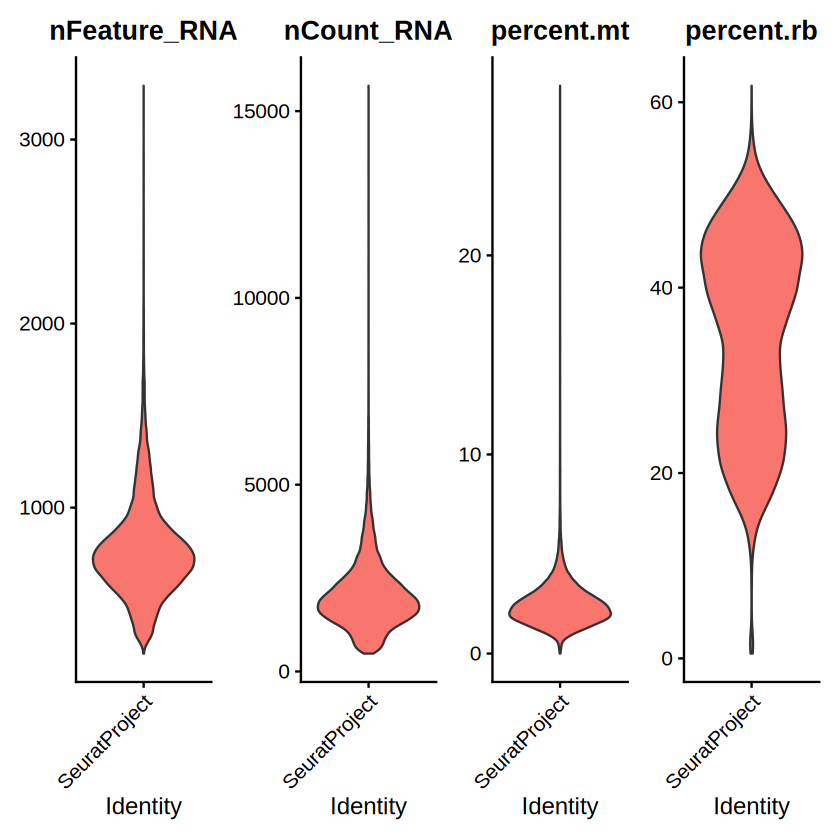

In [35]:
data3 <- Read10X("data/sample3")

sample3 <- CreateSeuratObject(counts = data3, min.cells = 3, min.features = 200)

# calculate mitocondrial percentages
sample3[["percent.mt"]] <- PercentageFeatureSet(sample3, pattern = "^MT-") #nolint

# calculate ribosome percentages
sample3[["percent.rb"]] <- PercentageFeatureSet(sample3, pattern = "^RP[SL]") #nolint

#For displaying in the work arena
VlnPlot(sample3, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb"), ncol = 4, pt.size = 0) # nolint

# Apply filtering
sample3 <- subset(sample3, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 15)

sample3 <- NormalizeData(sample3)

azimuth_anno3 <- read.table("azimuth_preds/s3_azimuth_pred.tsv", header=TRUE, sep="\t", row.names=1)

common_cells <- intersect(rownames(azimuth_anno3), Cells(sample3))
azimuth_anno3 <- azimuth_anno3[common_cells, ]

sample3 <- AddMetaData(sample3, metadata = azimuth_anno3)

str(sample3@meta.data)

## sample_4

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


'data.frame':	5416 obs. of  8 variables:
 $ orig.ident                 : Factor w/ 1 level "SeuratProject": 1 1 1 1 1 1 1 1 1 1 ...
 $ nCount_RNA                 : num  2028 2832 1804 1789 3153 ...
 $ nFeature_RNA               : int  641 1028 688 621 926 1189 833 672 1269 883 ...
 $ percent.mt                 : num  2.91 2.4 2.22 2.46 2.12 ...
 $ percent.rb                 : num  46.7 30.9 40.3 49.1 31.7 ...
 $ predicted.celltype.l2      : chr  "CD8 Naive" "CD14 Mono" "CD8 TCM" "CD4 TCM" ...
 $ predicted.celltype.l2.score: num  0.541 1 0.925 0.818 1 ...
 $ mapping.score              : num  0.635 0.69 0.949 0.747 0.872 ...


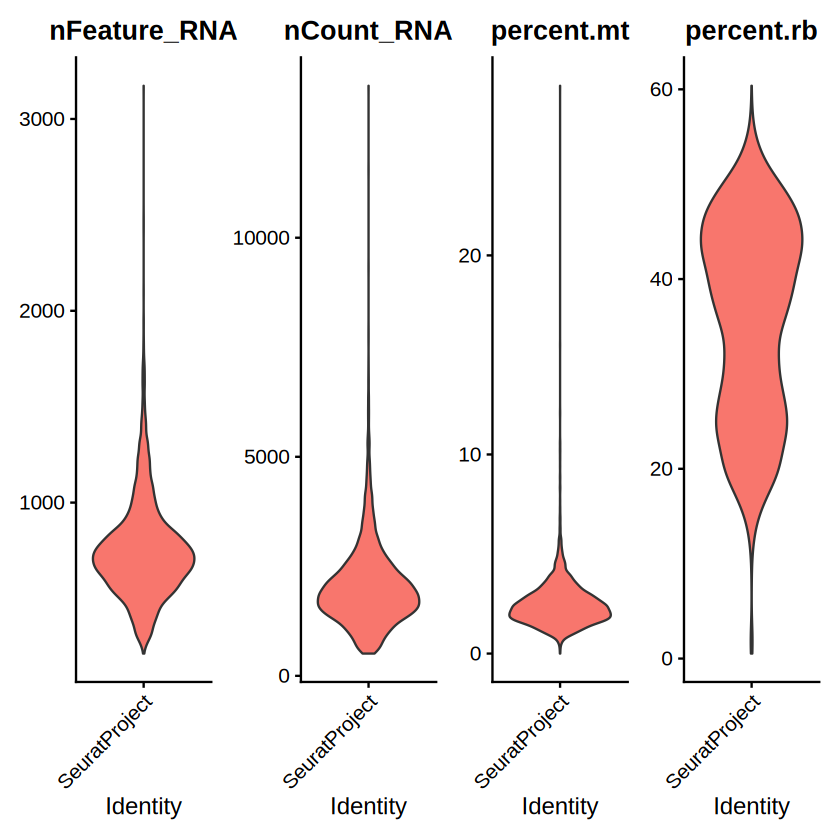

In [36]:
data4 <- Read10X("data/sample4")

sample4 <- CreateSeuratObject(counts = data4, min.cells = 3, min.features = 200)

# calculate mitocondrial percentages
sample4[["percent.mt"]] <- PercentageFeatureSet(sample4, pattern = "^MT-") #nolint

# calculate ribosome percentages
sample4[["percent.rb"]] <- PercentageFeatureSet(sample4, pattern = "^RP[SL]") #nolint

#For displaying in the work arena
VlnPlot(sample4, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb"), ncol = 4, pt.size = 0) # nolint

# Apply filtering
sample4 <- subset(sample4, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 15)

sample4 <- NormalizeData(sample4)

azimuth_anno4 <- read.table("azimuth_preds/s4_azimuth_pred.tsv", header=TRUE, sep="\t", row.names=1)

common_cells <- intersect(rownames(azimuth_anno4), Cells(sample4))
azimuth_anno4 <- azimuth_anno4[common_cells, ]

sample4 <- AddMetaData(sample4, metadata = azimuth_anno4)

str(sample4@meta.data)

## sample_5

'data.frame':	9941 obs. of  8 variables:
 $ orig.ident                 : Factor w/ 1 level "SeuratProject": 1 1 1 1 1 1 1 1 1 1 ...
 $ nCount_RNA                 : num  1548 6387 16664 3352 5914 ...
 $ nFeature_RNA               : int  729 1827 3744 1464 2036 4528 2794 2303 3196 1421 ...
 $ percent.mt                 : num  0.452 10.412 5.281 13.842 6.273 ...
 $ percent.rb                 : num  26.16 34.95 16.98 3.34 11.75 ...
 $ predicted.celltype.l2      : chr  "CD14 Mono" "MAIT" "CD14 Mono" "NK" ...
 $ predicted.celltype.l2.score: num  0.926 0.752 1 1 1 ...
 $ mapping.score              : num  0.519 0.985 0.944 0.868 0.929 ...


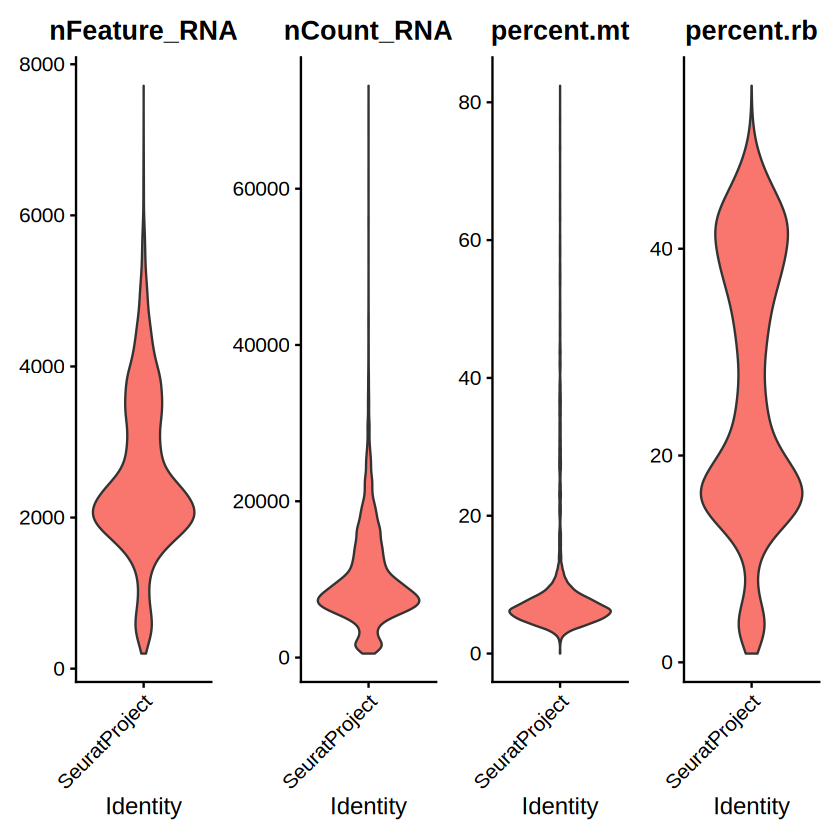

In [40]:
data5 <- Read10X_h5("data/sample5.h5")

sample5 <- CreateSeuratObject(counts = data5, min.cells = 3, min.features = 200)

# calculate mitocondrial percentages
sample5[["percent.mt"]] <- PercentageFeatureSet(sample5, pattern = "^MT-") #nolint

# calculate ribosome percentages
sample5[["percent.rb"]] <- PercentageFeatureSet(sample5, pattern = "^RP[SL]") #nolint

#For displaying in the work arena
VlnPlot(sample5, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb"), ncol = 4, pt.size = 0) # nolint

# Apply filtering
sample5 <- subset(sample5, subset = nFeature_RNA > 200 & nFeature_RNA < 6000 & percent.mt < 15)

sample5 <- NormalizeData(sample5)

azimuth_anno5 <- read.table("azimuth_preds/s5_azimuth_pred.tsv", header=TRUE, sep="\t", row.names=1)

common_cells <- intersect(rownames(azimuth_anno5), Cells(sample5))
azimuth_anno5 <- azimuth_anno5[common_cells, ]

sample5 <- AddMetaData(sample5, metadata = azimuth_anno5)

str(sample5@meta.data)

## sample_6

'data.frame':	22859 obs. of  8 variables:
 $ orig.ident                 : Factor w/ 1 level "SeuratProject": 1 1 1 1 1 1 1 1 1 1 ...
 $ nCount_RNA                 : num  9203 5704 8877 22005 626 ...
 $ nFeature_RNA               : int  3085 1844 2937 4854 407 3264 3058 1829 2048 3485 ...
 $ percent.mt                 : num  6.98 5.36 7.06 7.48 11.34 ...
 $ percent.rb                 : num  12.1 34.2 11.1 19.3 10.7 ...
 $ predicted.celltype.l2      : chr  "CD14 Mono" "CD8 Naive" "CD14 Mono" "CD16 Mono" ...
 $ predicted.celltype.l2.score: num  1 0.995 1 0.978 1 ...
 $ mapping.score              : num  0.899 0.757 0.912 0.551 0.451 ...


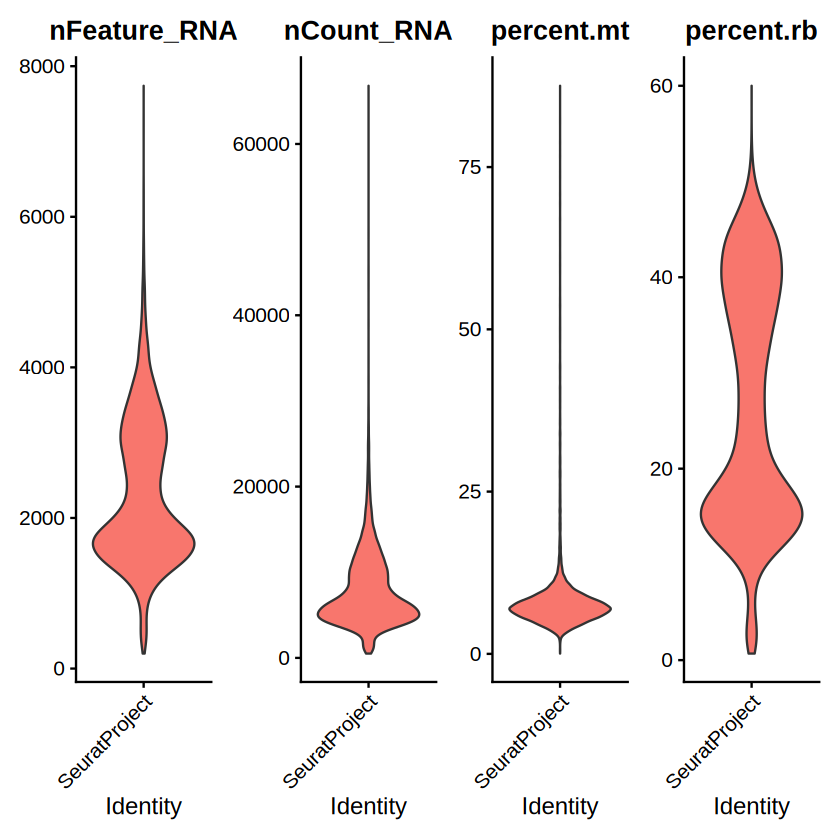

In [41]:
data6 <- Read10X_h5("data/sample6.h5")

sample6 <- CreateSeuratObject(counts = data6, min.cells = 3, min.features = 200)

# calculate mitocondrial percentages
sample6[["percent.mt"]] <- PercentageFeatureSet(sample6, pattern = "^MT-") #nolint

# calculate ribosome percentages
sample6[["percent.rb"]] <- PercentageFeatureSet(sample6, pattern = "^RP[SL]") #nolint

#For displaying in the work arena
VlnPlot(sample6, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb"), ncol = 4, pt.size = 0) # nolint

# Apply filtering
sample6 <- subset(sample6, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 15)

sample6 <- NormalizeData(sample6)

azimuth_anno6 <- read.table("azimuth_preds/s6_azimuth_pred.tsv", header=TRUE, sep="\t", row.names=1)

common_cells <- intersect(rownames(azimuth_anno6), Cells(sample6))
azimuth_anno6 <- azimuth_anno6[common_cells, ]

sample6 <- AddMetaData(sample6, metadata = azimuth_anno6)

str(sample6@meta.data)

## sample_7

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


'data.frame':	8377 obs. of  8 variables:
 $ orig.ident                 : Factor w/ 1 level "SeuratProject": 1 1 1 1 1 1 1 1 1 1 ...
 $ nCount_RNA                 : num  2393 1694 4520 2788 4665 ...
 $ nFeature_RNA               : int  870 806 1316 898 1524 1495 1253 1433 1632 1134 ...
 $ percent.mt                 : num  3.84 5.73 1.95 1.4 3.62 ...
 $ percent.rb                 : num  36.2 24.1 45.8 46.6 22.9 ...
 $ predicted.celltype.l2      : chr  "B naive" "CD14 Mono" "CD4 TCM" "CD4 TCM" ...
 $ predicted.celltype.l2.score: num  0.973 1 0.939 0.393 0.987 ...
 $ mapping.score              : num  0.975 0.847 0.783 0.636 0.944 ...


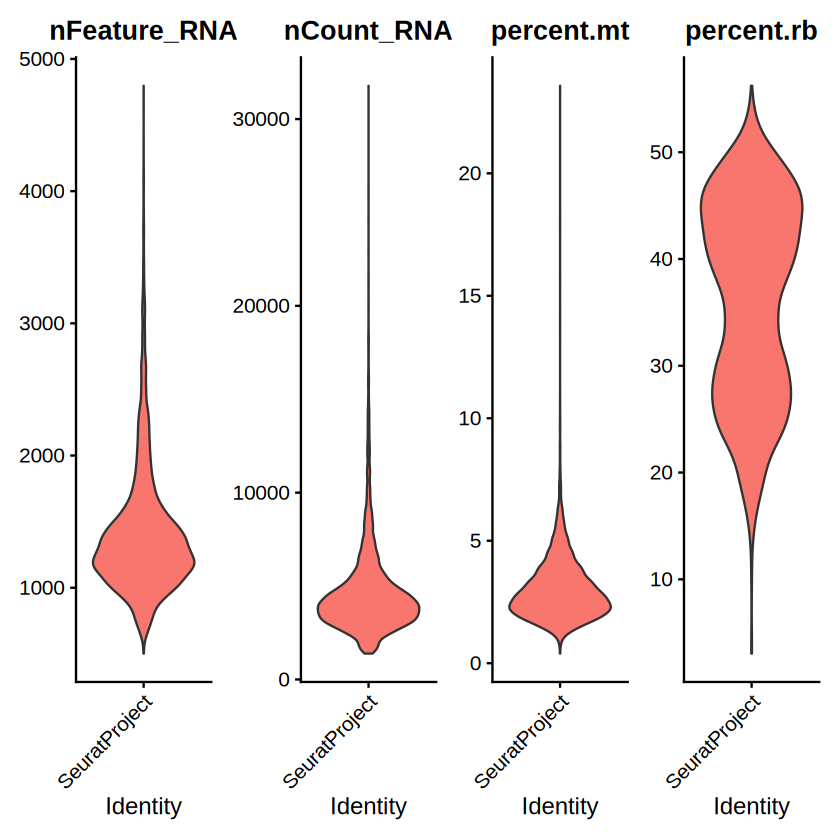

In [42]:
data7 <- Read10X("data/sample7")

sample7 <- CreateSeuratObject(counts = data7, min.cells = 3, min.features = 200)

# calculate mitocondrial percentages
sample7[["percent.mt"]] <- PercentageFeatureSet(sample7, pattern = "^MT-") #nolint

# calculate ribosome percentages
sample7[["percent.rb"]] <- PercentageFeatureSet(sample7, pattern = "^RP[SL]") #nolint

#For displaying in the work arena
VlnPlot(sample7, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb"), ncol = 4, pt.size = 0) # nolint

# Apply filtering
sample7 <- subset(sample7, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 15)

sample7 <- NormalizeData(sample7)

azimuth_anno7 <- read.table("azimuth_preds/s7_azimuth_pred.tsv", header=TRUE, sep="\t", row.names=1)

common_cells <- intersect(rownames(azimuth_anno7), Cells(sample7))
azimuth_anno7 <- azimuth_anno7[common_cells, ]

sample7 <- AddMetaData(sample7, metadata = azimuth_anno7)

str(sample7@meta.data)

## sample_8

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


'data.frame':	4335 obs. of  8 variables:
 $ orig.ident                 : Factor w/ 1 level "SeuratProject": 1 1 1 1 1 1 1 1 1 1 ...
 $ nCount_RNA                 : num  1738 3240 1683 2318 2983 ...
 $ nFeature_RNA               : int  748 1052 739 874 951 1248 1349 2785 865 2278 ...
 $ percent.mt                 : num  6.39 5.46 7.37 3.84 2.25 ...
 $ percent.rb                 : num  23.1 31 14.6 37 44.5 ...
 $ predicted.celltype.l2      : chr  "CD14 Mono" "CD14 Mono" "CD14 Mono" "CD4 TEM" ...
 $ predicted.celltype.l2.score: num  1 1 1 0.582 0.746 ...
 $ mapping.score              : num  0.955 0.951 0.946 0.882 0.641 ...


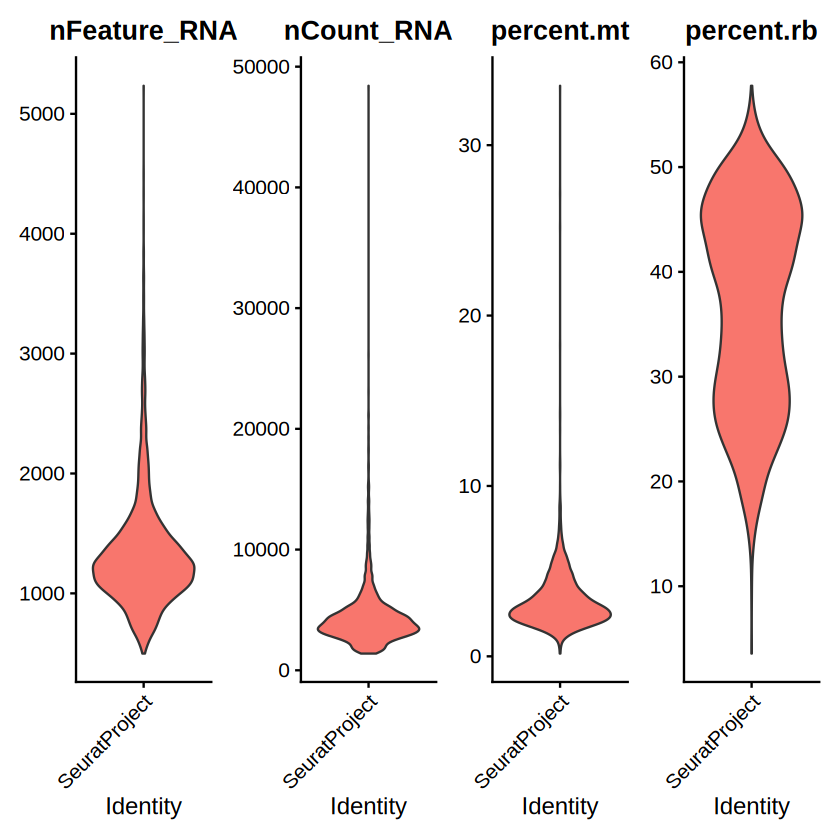

In [43]:
data8 <- Read10X("data/sample8")

sample8 <- CreateSeuratObject(counts = data8, min.cells = 3, min.features = 200)

# calculate mitocondrial percentages
sample8[["percent.mt"]] <- PercentageFeatureSet(sample8, pattern = "^MT-") #nolint

# calculate ribosome percentages
sample8[["percent.rb"]] <- PercentageFeatureSet(sample8, pattern = "^RP[SL]") #nolint

#For displaying in the work arena
VlnPlot(sample8, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb"), ncol = 4, pt.size = 0) # nolint

# Apply filtering
sample8 <- subset(sample8, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 15)

sample8 <- NormalizeData(sample8)

azimuth_anno8 <- read.table("azimuth_preds/s8_azimuth_pred.tsv", header=TRUE, sep="\t", row.names=1)

common_cells <- intersect(rownames(azimuth_anno8), Cells(sample8))
azimuth_anno8 <- azimuth_anno8[common_cells, ]

sample8 <- AddMetaData(sample8, metadata = azimuth_anno8)

str(sample8@meta.data)

## sample_9

Genome matrix has multiple modalities, returning a list of matrices for this genome



'data.frame':	9974 obs. of  8 variables:
 $ orig.ident                 : Factor w/ 1 level "SeuratProject": 1 1 1 1 1 1 1 1 1 1 ...
 $ nCount_RNA                 : num  2327 7600 5921 6777 6814 ...
 $ nFeature_RNA               : int  1126 2152 2399 2156 2451 4692 1967 1340 3291 2050 ...
 $ percent.mt                 : num  6.02 3.67 6 4.97 5.3 ...
 $ percent.rb                 : num  28.6 42.4 18.6 37.8 29.5 ...
 $ predicted.celltype.l2      : chr  "CD4 TCM" "CD4 TCM" "CD14 Mono" "CD4 TCM" ...
 $ predicted.celltype.l2.score: num  0.741 1 1 1 0.97 ...
 $ mapping.score              : num  0.749 0.981 0.787 0.93 0.8 ...


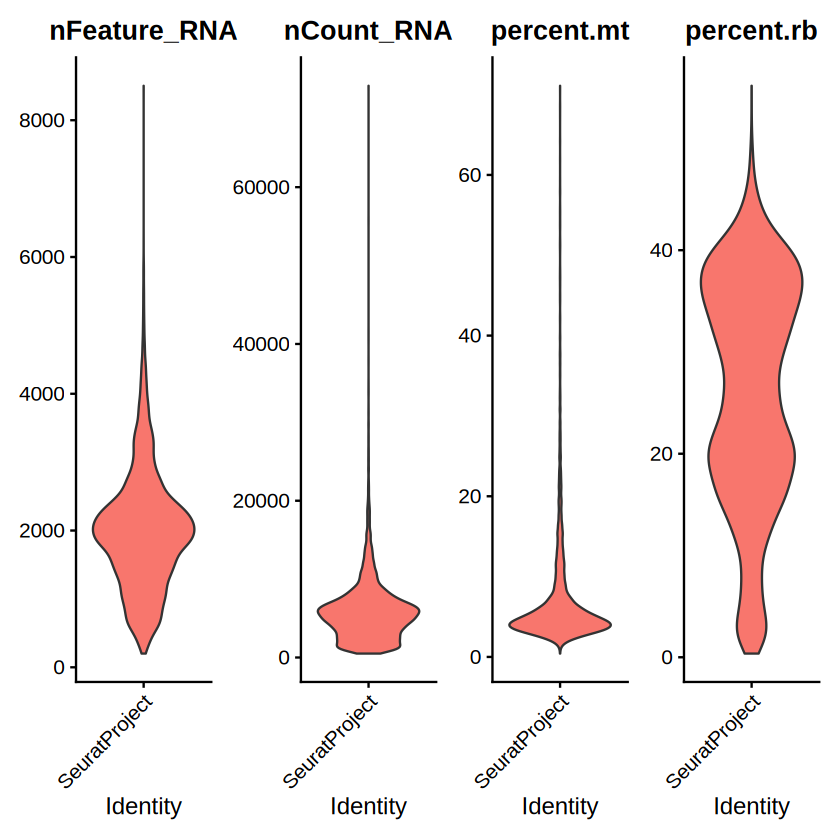

In [50]:
data9 <- Read10X_h5("data/sample9.h5")

gene_counts <- data9$`Gene Expression`

sample9 <- CreateSeuratObject(counts = gene_counts, min.cells = 3, min.features = 200)

# calculate mitocondrial percentages
sample9[["percent.mt"]] <- PercentageFeatureSet(sample9, pattern = "^MT-") #nolint

# calculate ribosome percentages
sample9[["percent.rb"]] <- PercentageFeatureSet(sample9, pattern = "^RP[SL]") #nolint

#For displaying in the work arena
VlnPlot(sample9, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb"), ncol = 4, pt.size = 0) # nolint

# Apply filtering
sample9 <- subset(sample9, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 15)

sample9 <- NormalizeData(sample9)

azimuth_anno9 <- read.table("azimuth_preds/s9_azimuth_pred.tsv", header=TRUE, sep="\t", row.names=1)

common_cells <- intersect(rownames(azimuth_anno9), Cells(sample9))
azimuth_anno9 <- azimuth_anno9[common_cells, ]

sample9 <- AddMetaData(sample9, metadata = azimuth_anno9)

str(sample9@meta.data)

## sample_10

'data.frame':	4028 obs. of  8 variables:
 $ orig.ident                 : Factor w/ 1 level "SeuratProject": 1 1 1 1 1 1 1 1 1 1 ...
 $ nCount_RNA                 : num  3811 4018 3778 5277 4424 ...
 $ nFeature_RNA               : int  1658 1201 1025 1531 1914 2317 1612 1100 1187 1875 ...
 $ percent.mt                 : num  9.42 4.95 3.26 7.71 7.48 ...
 $ percent.rb                 : num  14 45.5 51.2 41.7 11.9 ...
 $ predicted.celltype.l2      : chr  "NK" "CD4 Naive" "CD4 TCM" "CD8 Naive" ...
 $ predicted.celltype.l2.score: num  1 0.585 0.498 1 1 ...
 $ mapping.score              : num  0.989 0.857 0.878 0.887 0.986 ...


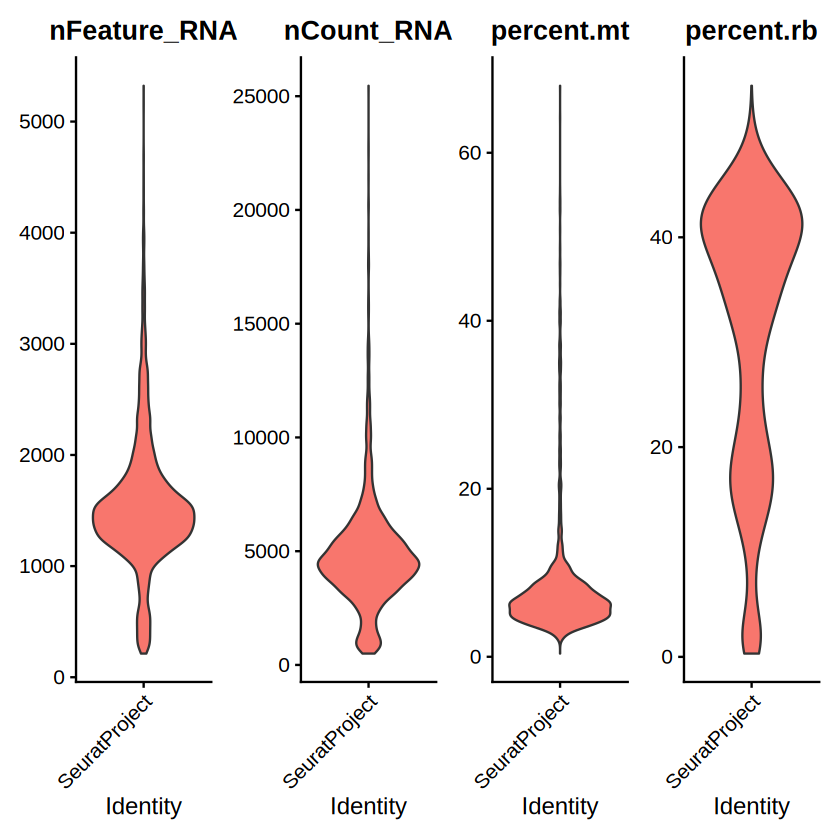

In [51]:
data10 <- Read10X_h5("data/sample10.h5")

sample10 <- CreateSeuratObject(counts = data10, min.cells = 3, min.features = 200)

# calculate mitocondrial percentages
sample10[["percent.mt"]] <- PercentageFeatureSet(sample10, pattern = "^MT-") #nolint

# calculate ribosome percentages
sample10[["percent.rb"]] <- PercentageFeatureSet(sample10, pattern = "^RP[SL]") #nolint

#For displaying in the work arena
VlnPlot(sample10, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb"), ncol = 4, pt.size = 0) # nolint

# Apply filtering
sample10 <- subset(sample10, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 15)

sample10 <- NormalizeData(sample10)

azimuth_anno10 <- read.table("azimuth_preds/s10_azimuth_pred.tsv", header=TRUE, sep="\t", row.names=1)

common_cells <- intersect(rownames(azimuth_anno10), Cells(sample10))
azimuth_anno10 <- azimuth_anno10[common_cells, ]

sample10 <- AddMetaData(sample10, metadata = azimuth_anno10)

str(sample10@meta.data)

## sample_11

Genome matrix has multiple modalities, returning a list of matrices for this genome



'data.frame':	6156 obs. of  8 variables:
 $ orig.ident                 : Factor w/ 1 level "SeuratProject": 1 1 1 1 1 1 1 1 1 1 ...
 $ nCount_RNA                 : num  16714 4340 7754 6232 6578 ...
 $ nFeature_RNA               : int  3878 1362 2028 2168 1631 2387 1367 2911 3789 3068 ...
 $ percent.mt                 : num  6.62 4.68 7.89 7.48 9.09 ...
 $ percent.rb                 : num  18.5 43.5 39.9 13.8 43 ...
 $ predicted.celltype.l2      : chr  "CD14 Mono" "CD4 Naive" "CD8 Naive" "CD14 Mono" ...
 $ predicted.celltype.l2.score: num  0.902 0.767 0.969 1 0.943 ...
 $ mapping.score              : num  0.95 0.954 0.746 0.908 0.84 ...


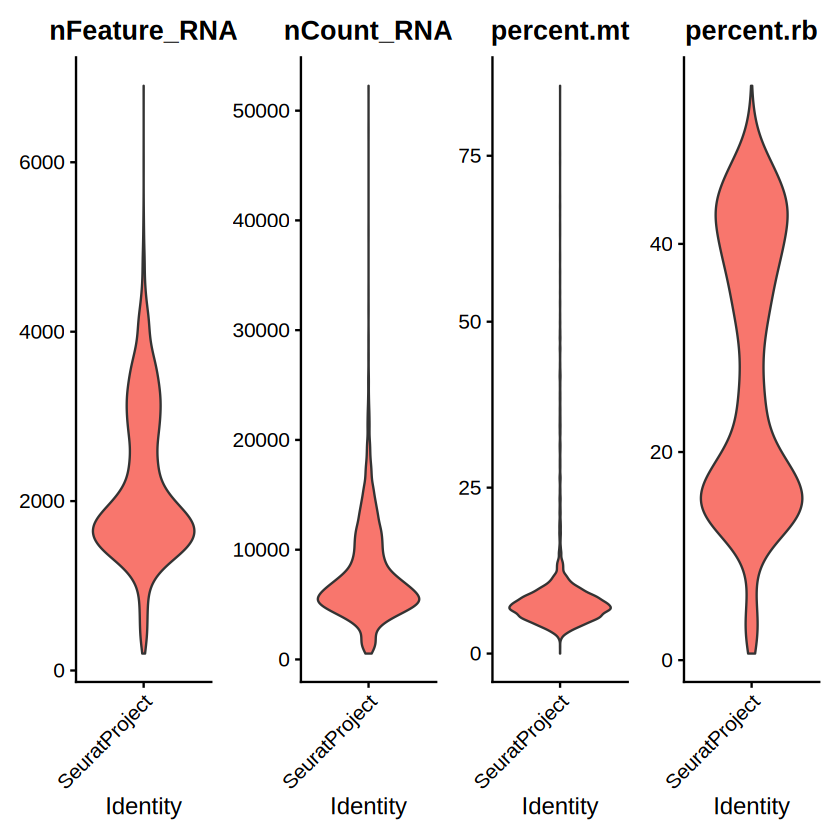

In [53]:
data11 <- Read10X_h5("data/sample11.h5")

gene_counts <- data11$`Gene Expression`

sample11 <- CreateSeuratObject(counts = gene_counts, min.cells = 3, min.features = 200)

# calculate mitocondrial percentages
sample11[["percent.mt"]] <- PercentageFeatureSet(sample11, pattern = "^MT-") #nolint

# calculate ribosome percentages
sample11[["percent.rb"]] <- PercentageFeatureSet(sample11, pattern = "^RP[SL]") #nolint

#For displaying in the work arena
VlnPlot(sample11, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb"), ncol = 4, pt.size = 0) # nolint

# Apply filtering
sample11 <- subset(sample11, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 15)

sample11 <- NormalizeData(sample11)

azimuth_anno11 <- read.table("azimuth_preds/s11_azimuth_pred.tsv", header=TRUE, sep="\t", row.names=1)

common_cells <- intersect(rownames(azimuth_anno11), Cells(sample11))
azimuth_anno11 <- azimuth_anno11[common_cells, ]

sample11 <- AddMetaData(sample11, metadata = azimuth_anno11)

str(sample11@meta.data)

## sample_12

Genome matrix has multiple modalities, returning a list of matrices for this genome



'data.frame':	4317 obs. of  8 variables:
 $ orig.ident                 : Factor w/ 1 level "SeuratProject": 1 1 1 1 1 1 1 1 1 1 ...
 $ nCount_RNA                 : num  7359 3764 4894 6699 3893 ...
 $ nFeature_RNA               : int  2359 1255 1575 1904 1586 3132 1443 2697 2781 1491 ...
 $ percent.mt                 : num  6.33 9.11 13.18 6.36 9.32 ...
 $ percent.rb                 : num  15.8 28.8 30.5 38 12.2 ...
 $ predicted.celltype.l2      : chr  "CD14 Mono" "CD4 TCM" "CD4 TEM" "CD4 TCM" ...
 $ predicted.celltype.l2.score: num  1 0.368 0.652 0.95 1 ...
 $ mapping.score              : num  0.962 0.442 0.988 0.823 0.827 ...


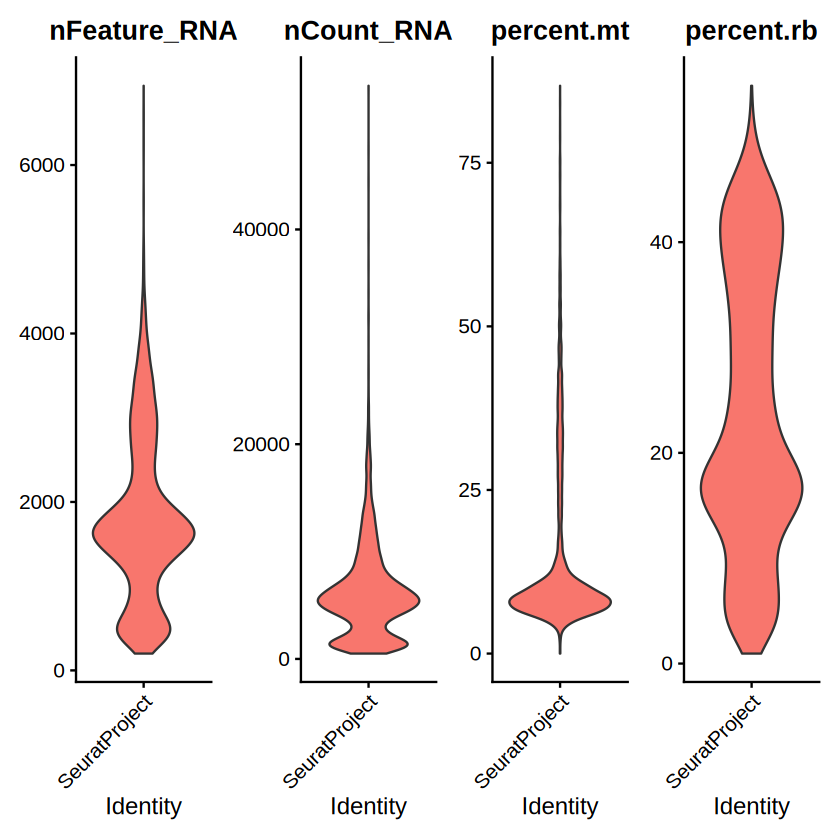

In [58]:
data12 <- Read10X_h5("data/sample12.h5")

gene_counts <- data12$`Gene Expression`

sample12 <- CreateSeuratObject(counts = gene_counts, min.cells = 3, min.features = 200)

# calculate mitocondrial percentages
sample12[["percent.mt"]] <- PercentageFeatureSet(sample12, pattern = "^MT-") #nolint

# calculate ribosome percentages
sample12[["percent.rb"]] <- PercentageFeatureSet(sample12, pattern = "^RP[SL]") #nolint

#For displaying in the work arena
VlnPlot(sample12, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb"), ncol = 4, pt.size = 0) # nolint

# Apply filtering
sample12 <- subset(sample12, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 25)

sample12 <- NormalizeData(sample12)

azimuth_anno12 <- read.table("azimuth_preds/s12_azimuth_pred.tsv", header=TRUE, sep="\t", row.names=1)

common_cells <- intersect(rownames(azimuth_anno12), Cells(sample12))
azimuth_anno12 <- azimuth_anno12[common_cells, ]

sample12 <- AddMetaData(sample12, metadata = azimuth_anno12)

str(sample12@meta.data)

## sample_13

Genome matrix has multiple modalities, returning a list of matrices for this genome



'data.frame':	4488 obs. of  8 variables:
 $ orig.ident                 : Factor w/ 1 level "SeuratProject": 1 1 1 1 1 1 1 1 1 1 ...
 $ nCount_RNA                 : num  4428 7106 11059 4838 4243 ...
 $ nFeature_RNA               : int  1685 2290 3185 1850 1409 1593 1910 1686 1815 3329 ...
 $ percent.mt                 : num  11.92 5.95 7.81 7.67 4.74 ...
 $ percent.rb                 : num  11.7 21 21.1 18.4 37.9 ...
 $ predicted.celltype.l2      : chr  "CD14 Mono" "CD14 Mono" "CD14 Mono" "CD14 Mono" ...
 $ predicted.celltype.l2.score: num  1 0.961 1 1 0.815 ...
 $ mapping.score              : num  0.949 0.777 0.681 0.983 0.949 ...


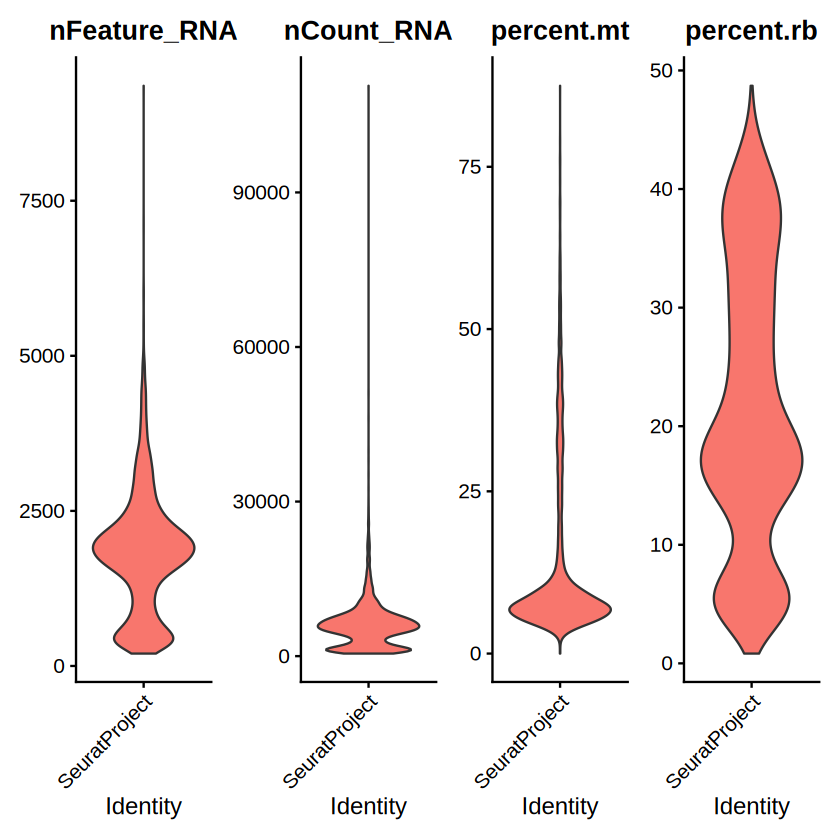

In [61]:
data13 <- Read10X_h5("data/sample13.h5")

gene_counts <- data13$`Gene Expression`

sample13 <- CreateSeuratObject(counts = gene_counts, min.cells = 3, min.features = 200)

# calculate mitocondrial percentages
sample13[["percent.mt"]] <- PercentageFeatureSet(sample13, pattern = "^MT-") #nolint

# calculate ribosome percentages
sample13[["percent.rb"]] <- PercentageFeatureSet(sample13, pattern = "^RP[SL]") #nolint

#For displaying in the work arena
VlnPlot(sample13, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb"), ncol = 4, pt.size = 0) # nolint

# Apply filtering
sample13 <- subset(sample13, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 25)

sample13 <- NormalizeData(sample13)

azimuth_anno13 <- read.table("azimuth_preds/s13_azimuth_pred.tsv", header=TRUE, sep="\t", row.names=1)

common_cells <- intersect(rownames(azimuth_anno13), Cells(sample13))
azimuth_anno13 <- azimuth_anno13[common_cells, ]

sample13 <- AddMetaData(sample13, metadata = azimuth_anno13)

str(sample13@meta.data)

## Integration - Batch Effect Correction

In [63]:
# List of all 13 objects
seurat_list <- list(sample1, sample2, sample3, sample4, sample5, sample6, sample7, sample8, sample9, sample10, sample11, sample12, sample13)  


seurat_list <- lapply(seurat_list, function(pbmc_obj) {
  pbmc_obj <- FindVariableFeatures(pbmc_obj, selection.method = "vst", nfeatures = 2000)
  return(pbmc_obj)
})

In [64]:
features <- SelectIntegrationFeatures(object.list = seurat_list)

In [ ]:
anchors <- FindIntegrationAnchors(object.list = seurat_list, anchor.features = features)

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 10370 anchors

Filtering anchors

	Retained 6452 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 34896 anchors

Filtering anchors

	Retained 5653 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 12537 anchors

Filtering anchors

	Retained 2574 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 16485 anchors

Filtering anchors

	Retained 7305 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9919 anchors

Filtering anchors

	Retained 4680 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 23942 anchor

In [67]:
integrated <- IntegrateData(anchorset = anchors)

Merging dataset 4 into 3

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 11 into 6

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 8 into 7

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 12 into 5

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 10 into 9

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 13 into 5 12

Extracting anchors for merged samples

Finding integration vectors

Finding int

In [68]:
DefaultAssay(integrated) <- "integrated"

In [69]:
integrated_temp <- ScaleData(integrated)
integrated_temp <- RunPCA(integrated_temp, npcs = 30)
integrated_temp <- RunUMAP(integrated_temp, dims = 1:30)
integrated_temp <- FindNeighbors(integrated_temp, dims = 1:30)
integrated_temp <- FindClusters(integrated_temp, resolution = 0.5)

Centering and scaling data matrix

PC_ 1 
Positive:  FGL2, FCN1, MNDA, CST3, LYZ, CYBB, IFI30, CTSS, TYMP, S100A9 
	   NCF2, AIF1, TMEM176B, MPEG1, TYROBP, PSAP, LST1, IGSF6, SERPINA1, DUSP6 
	   CSTA, KCTD12, CD36, S100A8, VCAN, TNFAIP2, FTL, TNFSF13B, DMXL2, CLEC7A 
Negative:  ETS1, LTB, BCL11B, IL32, MALAT1, CD3D, LIME1, CD3G, IL7R, ARL4C 
	   LINC00861, CD2, BCL2, IKZF3, TCF7, SYNE2, SPOCK2, RASGRP1, CD27, CD7 
	   CCR7, CCND2, OXNAD1, LEF1, CD247, RCAN3, CAMK4, GZMM, NOSIP, RORA 
PC_ 2 
Positive:  GZMA, NKG7, S100A4, CST7, CTSW, IL32, GZMM, GNLY, PRF1, KLRD1 
	   KLRK1, CD247, CCL5, CD2, ANXA1, ARL4C, SAMD3, FGFBP2, CD7, CD3D 
	   SYNE2, PYHIN1, MYBL1, LIME1, GZMH, CD3G, TMSB4X, KLRB1, BCL11B, KLRF1 
Negative:  CD79A, MS4A1, RALGPS2, BANK1, TNFRSF13C, AFF3, BCL11A, PAX5, LINC00926, CD22 
	   CD79B, FCRL1, COBLL1, HLA-DQA1, SWAP70, SPIB, VPREB3, TCF4, BLK, FCER2 
	   HLA-DRA, TCL1A, FCRL2, CD74, ADAM28, HLA-DRB1, TLR10, COL19A1, FCRL5, MEF2C 
PC_ 3 
Positive:  GNLY, NKG7, GZMB, KLR

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 127216
Number of edges: 6181064

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9367
Number of communities: 28
Elapsed time: 68 seconds


2 singletons identified. 26 final clusters.



Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



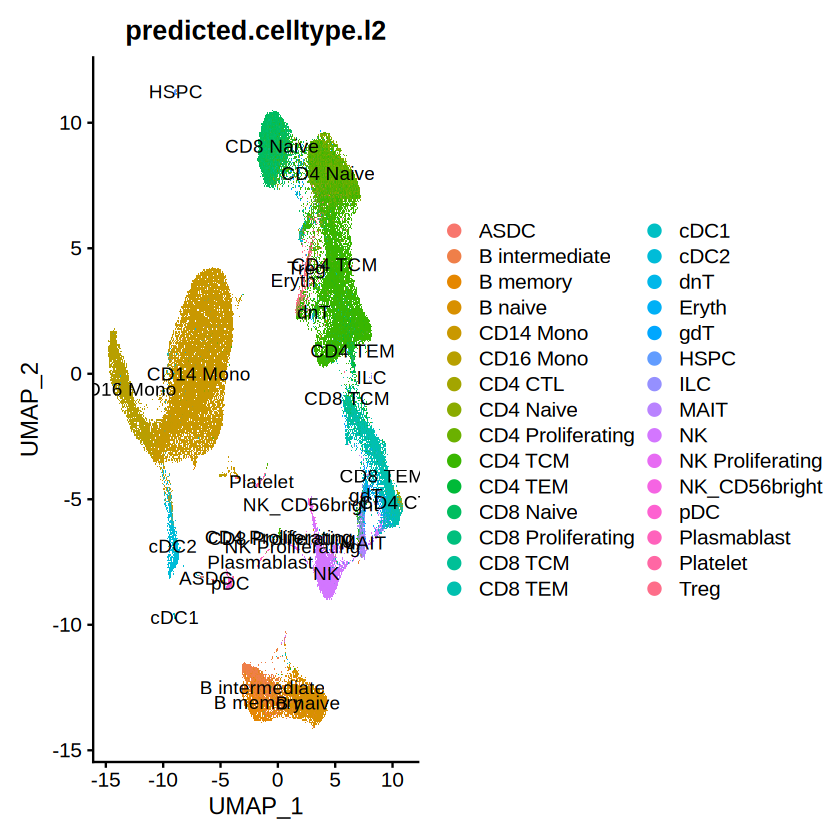

In [72]:
DimPlot(integrated_temp, group.by = "predicted.celltype.l2", label = TRUE)

In [71]:
str(integrated_temp@meta.data)

'data.frame':	127216 obs. of  10 variables:
 $ orig.ident                 : chr  "SeuratProject" "SeuratProject" "SeuratProject" "SeuratProject" ...
 $ nCount_RNA                 : num  12143 7810 9741 5561 7398 ...
 $ nFeature_RNA               : int  3022 2666 2934 1525 2077 1549 2520 4491 1158 1749 ...
 $ percent.mt                 : num  6.41 6.31 8.64 5.2 8.87 ...
 $ percent.rb                 : num  19.6 12.9 17.9 45.6 35.3 ...
 $ predicted.celltype.l2      : chr  "CD16 Mono" "CD14 Mono" "CD14 Mono" "CD4 TCM" ...
 $ predicted.celltype.l2.score: num  1 1 0.795 0.569 0.9 ...
 $ mapping.score              : num  0.894 0.952 0.827 0.873 0.958 ...
 $ integrated_snn_res.0.5     : Factor w/ 26 levels "0","1","10","11",..: 26 2 4 13 3 22 2 15 13 21 ...
 $ seurat_clusters            : Factor w/ 26 levels "0","1","2","3",..: 10 2 12 3 11 6 2 22 3 5 ...


In [73]:
str(integrated@meta.data)

'data.frame':	127216 obs. of  8 variables:
 $ orig.ident                 : chr  "SeuratProject" "SeuratProject" "SeuratProject" "SeuratProject" ...
 $ nCount_RNA                 : num  12143 7810 9741 5561 7398 ...
 $ nFeature_RNA               : int  3022 2666 2934 1525 2077 1549 2520 4491 1158 1749 ...
 $ percent.mt                 : num  6.41 6.31 8.64 5.2 8.87 ...
 $ percent.rb                 : num  19.6 12.9 17.9 45.6 35.3 ...
 $ predicted.celltype.l2      : chr  "CD16 Mono" "CD14 Mono" "CD14 Mono" "CD4 TCM" ...
 $ predicted.celltype.l2.score: num  1 1 0.795 0.569 0.9 ...
 $ mapping.score              : num  0.894 0.952 0.827 0.873 0.958 ...


In [74]:
table(seurat_list[[1]]$orig.ident)



SeuratProject 
        11506 

In [75]:
integrated@assays

$RNA
Assay data with 30633 features for 127216 cells
First 10 features:
 AL627309.1, AL627309.3, AL627309.5, AL627309.4, AL669831.2, LINC01409,
FAM87B, LINC01128, LINC00115, FAM41C 

$integrated
Assay data with 2000 features for 127216 cells
Top 10 variable features:
 PPBP, PTGDS, GNLY, FCER1A, PF4, GZMB, MZB1, S100A9, C1QB, C1QA 


In [76]:
table(integrated$predicted.celltype.l2)


             ASDC    B intermediate          B memory           B naive 
               33              3483              2193              7656 
        CD14 Mono         CD16 Mono           CD4 CTL         CD4 Naive 
            33289              6351               174              7114 
CD4 Proliferating           CD4 TCM           CD4 TEM         CD8 Naive 
               83             30750              1335              9072 
CD8 Proliferating           CD8 TCM           CD8 TEM              cDC1 
               20              2400              8636                89 
             cDC2               dnT             Eryth               gdT 
             1722               212               161              1436 
             HSPC               ILC              MAIT                NK 
              155                46              1814              6085 
 NK Proliferating     NK_CD56bright               pDC       Plasmablast 
              160               370               

In [90]:
# Define the unwanted cell types
exclude_types <- c(
  "Plasmablast", "Platelet", "gdT", "MAIT", 
  "Eryth", "ILC", "dnT", "HSPC", 
  "CD4 Proliferating", "CD8 Proliferating", "NK_CD56bright",
  "NK Proliferating", "CD4 CTL"
)

# Use metadata directly to get cell names to keep
cells_to_keep <- rownames(integrated@meta.data)[
  !(integrated@meta.data$predicted.celltype.l2 %in% exclude_types)
]

# Subset using cell names
integrated_filtered <- subset(integrated, cells = cells_to_keep)

In [87]:
table(integrated_filtered$predicted.celltype.l2)



          ASDC B intermediate       B memory        B naive      CD14 Mono 
            33           3483           2193           7656          33289 
     CD16 Mono        CD4 CTL      CD4 Naive        CD4 TCM        CD4 TEM 
          6351            174           7114          30750           1335 
     CD8 Naive        CD8 TCM        CD8 TEM           cDC1           cDC2 
          9072           2400           8636             89           1722 
            NK            pDC           Treg 
          6085            782           1022 

In [91]:
# Define the cell types you want to relabel
dendritic_labels <- c("ASDC", "pDC", "cDC1", "cDC2")

# Replace them with "Dendritic cells"
integrated_filtered$predicted.celltype.l2[
  integrated_filtered$predicted.celltype.l2 %in% dendritic_labels
] <- "Dendritic cells"

In [92]:
table(integrated_filtered$predicted.celltype.l2)


 B intermediate        B memory         B naive       CD14 Mono       CD16 Mono 
           3483            2193            7656           33289            6351 
      CD4 Naive         CD4 TCM         CD4 TEM       CD8 Naive         CD8 TCM 
           7114           30750            1335            9072            2400 
        CD8 TEM Dendritic cells              NK            Treg 
           8636            2626            6085            1022 

In [94]:
# Desired number of cells to keep
downsample_targets <- list("CD14 Mono" = 9670, "CD4 TCM" = 9250)

# Get cells of those types and sample them
cells_to_keep <- unlist(lapply(names(downsample_targets), function(celltype) {
  cells <- colnames(integrated_filtered)[integrated_filtered$predicted.celltype.l2 == celltype]
  sample(cells, downsample_targets[[celltype]])
}))

# Keep all other cells not in those cell types
other_cells <- colnames(integrated_filtered)[
  !integrated_filtered$predicted.celltype.l2 %in% names(downsample_targets)
]

# Combine and subset
final_cells <- c(cells_to_keep, other_cells)
integrated_downsampled <- subset(integrated_filtered, cells = final_cells)


In [96]:
table(integrated_downsampled$predicted.celltype.l2)


 B intermediate        B memory         B naive       CD14 Mono       CD16 Mono 
           3483            2193            7656            9670            6351 
      CD4 Naive         CD4 TCM         CD4 TEM       CD8 Naive         CD8 TCM 
           7114            9250            1335            9072            2400 
        CD8 TEM Dendritic cells              NK            Treg 
           8636            2626            6085            1022 

In [97]:
str(integrated_downsampled@meta.data)

'data.frame':	76893 obs. of  8 variables:
 $ orig.ident                 : chr  "SeuratProject" "SeuratProject" "SeuratProject" "SeuratProject" ...
 $ nCount_RNA                 : num  2110 11186 17209 6962 9608 ...
 $ nFeature_RNA               : int  887 3230 4074 1810 2888 5808 729 758 1132 3312 ...
 $ percent.mt                 : num  6.4 6.8 8.93 3.91 5.77 ...
 $ percent.rb                 : num  25.4 17.5 15.1 38.4 15.5 ...
 $ predicted.celltype.l2      : chr  "CD14 Mono" "CD14 Mono" "CD14 Mono" "CD14 Mono" ...
 $ predicted.celltype.l2.score: num  1 0.824 1 1 1 ...
 $ mapping.score              : num  0.968 0.955 0.84 0.791 0.901 ...


In [99]:
integrated_downsampled@assays

$RNA
Assay data with 30633 features for 76893 cells
First 10 features:
 AL627309.1, AL627309.3, AL627309.5, AL627309.4, AL669831.2, LINC01409,
FAM87B, LINC01128, LINC00115, FAM41C 

$integrated
Assay data with 2000 features for 76893 cells
Top 10 variable features:
 PPBP, PTGDS, GNLY, FCER1A, PF4, GZMB, MZB1, S100A9, C1QB, C1QA 


In [116]:
# Set the default assay to 'integrated'
DefaultAssay(integrated_downsampled) <- "integrated"

# Get batch-corrected matrix
batch_corrected_matrix <- GetAssayData(integrated_downsampled, slot = "data")

# Get properly named cell types
cell_types_vector <- setNames(integrated_downsampled@meta.data$predicted.celltype.l2,
                              rownames(integrated_downsampled@meta.data))

# Transpose
expr_transposed <- t(batch_corrected_matrix)

# Create dataframe with cell types
expr_with_celltypes <- as.data.frame(expr_transposed)
expr_with_celltypes$CellType <- cell_types_vector[rownames(expr_with_celltypes)]


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.1 GiB”


In [118]:
tail(expr_with_celltypes)

,PPBP,PTGDS,GNLY,FCER1A,PF4,GZMB,MZB1,S100A9,C1QB,C1QA,⋯,SLBP,SLC25A22,TMEM205,MORC2,CD1B,PPIL2,TCF19,PRKCB,SKA1,CellType
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
TTTGACTGTGCAACGA-1_13,0.004756710,-0.0620927741,4.20171011,0.0027989224,-0.0017072128,2.34771679,0.006545235,0.3386025,2.988170e-05,0.0002649428,⋯,0.75765285,0.06030802,0.108574459,-0.01145705,-2.089560e-04,0.03226500,0.015595716,0.2815613,0.045746317,NK
TTTGATCCAAGGAGTC-1_13,-0.042934266,0.0083274722,0.48287817,0.0008141091,-0.0036054701,-0.01759995,0.063568293,0.4883139,-1.072092e-04,-0.0003899340,⋯,0.01513899,-0.02672882,0.620038379,0.24443455,1.347346e-04,0.09841483,0.047938816,0.8251097,0.003682912,CD8 TCM
TTTGATCGTTAAGCAA-1_13,-0.016022599,0.0392326400,0.08927276,0.0003790165,0.0091704233,-0.01313157,0.084648591,0.3015634,1.246428e-04,-0.0020115524,⋯,0.26835232,-0.01081118,0.002754268,0.06290637,2.078391e-06,0.14467859,-0.022306025,0.1450001,0.005384978,CD8 TEM
TTTGATCGTTACGCCG-1_13,0.011550866,-0.0001013118,0.03844892,-0.0022276879,0.0002869666,0.03235800,0.032887316,0.4060477,3.154438e-06,-0.0003933022,⋯,0.91734166,-0.13073184,0.982964212,0.19218255,1.001257e-05,-0.08716382,0.010763918,-0.1236033,0.001091438,CD8 Naive
TTTGGAGAGGTAGCCA-1_13,0.008656767,0.0176649593,0.01818113,-0.0009883383,0.0028772331,0.02319551,0.003069818,0.2798920,1.769306e-04,0.0006292918,⋯,0.16920161,-0.04679625,-0.012164239,0.02891430,9.961498e-06,-0.01062961,-0.009455266,1.0280994,-0.012919467,CD4 Naive
TTTGGAGGTATCGATC-1_13,0.005217159,0.0441866425,0.13033608,0.0003116503,0.0017193294,0.03307773,-0.083293062,0.3551601,-3.922759e-05,-0.0010331634,⋯,0.10659775,-0.05597758,-0.045497119,0.12000124,2.910358e-05,0.06113624,-0.065437654,-0.1351213,0.009081246,CD4 TEM


In [119]:
write.csv(expr_with_celltypes, "batch_corrected_expression_with_celltypes.csv", row.names = TRUE)


In [120]:
write.table(expr_with_celltypes, "batch_corrected_expression_with_celltypes.tsv", 
            sep = "\t", quote = FALSE, row.names = TRUE, col.names = NA)
